In [1]:
#optimal transport library
import ot

from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn

#statistics
import scipy

#machine learning library for time series
import numba
from numba import jit, njit

import tqdm
from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')

import dfply
from dfply import *
import math
import seaborn as sns
from scipy import stats
import sklearn
from sklearn import covariance
import itertools
import copy
import math


import matplotlib.pyplot as plt
import torch
import datetime
from datetime import date
from eod import EodHistoricalData

import os
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow.experimental.numpy as tnp
tnp.experimental_enable_numpy_behavior()

#import helpers
import ray
import pytz
import time
#misc
%matplotlib inline
plt.style.use('matplotlibrc')


/Users/hetankevin/miniforge3/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
retChar = pd.read_csv('data/RetChar.csv')

In [175]:
#fundamentals = pd.read_stata('data/csrpQuarterly.dta')

In [6]:
#print([col for col in fundamentals.columns])

In [7]:
#csrp.columns

In [184]:
retChar.columns

Index(['Date', 'ret', 'A2ME', 'AC', 'AT', 'ATO', 'BEME', 'Beta', 'C', 'CF',
       'CF2P', 'CTO', 'D2A', 'D2P', 'DPI2A', 'E2P', 'FC2Y', 'IdioVol',
       'Investment', 'Lev', 'LME', 'LT_Rev', 'LTurnover', 'MktBeta', 'NI',
       'NOA', 'OA', 'OL', 'OP', 'PCM', 'PM', 'PROF', 'Q', 'r2_1', 'r12_2',
       'r12_7', 'r36_13', 'Rel2High', 'Resid_Var', 'RNA', 'ROA', 'ROE', 'S2P',
       'SGA2S', 'Spread', 'ST_REV', 'SUV', 'Variance'],
      dtype='object')

In [3]:
csrp = pd.read_stata('data/csrpMonthly.dta')
csrp.index = csrp.datadate
csrp.trt1m /= 100
stockRets = csrp[['tic', 'trt1m']]
stockRets = stockRets.drop_duplicates()
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day
dateArr = np.array(list(map(to_integer, stockRets.index)))
stockRets['date'] = dateArr
stockRets.columns = ['tic', 'ret', 'Date']
stockRets['DR'] = stockRets['Date'] + stockRets['ret']
stockRets = stockRets.dropna()
#mergedRets = retCharDR[['DR']].merge(stockRets, on=['DR'])
#mergedRets

(array([1.30000e+01, 5.00000e+00, 1.00000e+01, 0.00000e+00, 7.00000e+00,
        2.00000e+00, 1.00000e+01, 5.00000e+00, 1.30000e+01, 1.40000e+01,
        1.20000e+01, 7.00000e+00, 2.40000e+01, 5.00000e+00, 2.70000e+01,
        1.80000e+01, 2.40000e+01, 2.20000e+01, 2.20000e+01, 2.40000e+01,
        3.30000e+01, 3.90000e+01, 3.30000e+01, 4.30000e+01, 3.90000e+01,
        7.10000e+01, 5.20000e+01, 6.00000e+01, 8.20000e+01, 6.30000e+01,
        1.08000e+02, 1.15000e+02, 1.21000e+02, 2.03000e+02, 1.71000e+02,
        2.86000e+02, 4.46000e+02, 4.10000e+02, 7.45000e+02, 8.38000e+02,
        1.17600e+03, 1.49100e+03, 2.12200e+03, 2.61000e+03, 3.33200e+03,
        4.78800e+03, 6.11900e+03, 8.25600e+03, 1.12000e+04, 1.46480e+04,
        1.95710e+04, 2.56990e+04, 3.26020e+04, 4.13390e+04, 5.14830e+04,
        6.32610e+04, 7.61120e+04, 8.89150e+04, 1.03805e+05, 1.18079e+05,
        1.31710e+05, 1.44016e+05, 1.54754e+05, 1.63509e+05, 1.69027e+05,
        1.72493e+05, 1.72768e+05, 1.72582e+05, 1.70

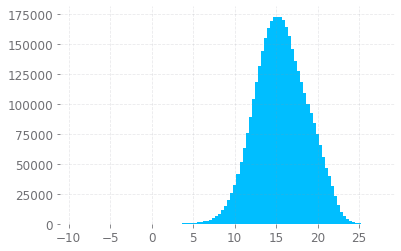

In [4]:
dollars = csrp.cshtrm * csrp.prccm
dollars > dollars.median()
plt.hist(np.log(dollars), bins=100)

In [9]:
#retChar['DR'] = retChar['Date'] + retChar['ret']
#mergedRets = pd.merge_asof(retChar.sort_values('DR'), stockRets.sort_values('DR')[['tic', 'DR']], on='DR', direction='nearest')
#mergedRets = mergedRets.drop('DR', 1)

In [5]:
datesTrain = np.load('data/datasets/char/Char_train.npz')['date']
variablesTrain = np.load('data/datasets/char/Char_train.npz')['variable']
trainSet = np.load('data/datasets/char/Char_train.npz')['data'].transpose(1, 0, 2)

datesVal = np.load('data/datasets/char/Char_valid.npz')['date']
variablesVal = np.load('data/datasets/char/Char_valid.npz')['variable']
valSet = np.load('data/datasets/char/Char_valid.npz')['data'].transpose(1, 0, 2)

datesTest = np.load('data/datasets/char/Char_test.npz')['date']
variablesTest = np.load('data/datasets/char/Char_test.npz')['variable']
testSet = np.load('data/datasets/char/Char_test.npz')['data'].transpose(1, 0, 2)

In [12]:
trainSet.shape

(3686, 240, 47)

In [13]:
valSet.shape

(3347, 60, 47)

In [15]:
testSet.shape

(7141, 300, 47)

In [6]:
trainDF = pd.DataFrame(trainSet.reshape(trainSet.shape[0]*trainSet.shape[1],
                                        trainSet.shape[2]), 
                       index = pd.MultiIndex.from_product([[i for i in range(trainSet.shape[0])],
                                                        datesTrain]),
                       columns = variablesTrain)

valDF = pd.DataFrame(valSet.reshape(valSet.shape[0]*valSet.shape[1],
                                        valSet.shape[2]), 
                       index = pd.MultiIndex.from_product([[i for i in range(valSet.shape[0])],
                                                        datesVal]),
                       columns = variablesVal)

testDF = pd.DataFrame(testSet.reshape(testSet.shape[0]*testSet.shape[1],
                                        testSet.shape[2]), 
                       index = pd.MultiIndex.from_product([[i for i in range(testSet.shape[0])],
                                                        datesTest]),
                       columns = variablesTest)
trainDF

ret      A2ME        AC        AT       ATO      BEME  \
0    19670131  0.136223  0.108392  0.243590  0.152681 -0.182984  0.113054   
     19670228 -0.039703  0.108392  0.241259  0.150350 -0.187646  0.117716   
     19670331  0.152727  0.109302  0.241860  0.148837 -0.188372  0.118605   
     19670428  0.048883  0.109195  0.242529  0.150575 -0.182759  0.116092   
     19670531 -0.022112  0.110599  0.241935  0.154378 -0.184332  0.115207   
...                 ...       ...       ...       ...       ...       ...   
3685 19860829 -0.010414  0.048148 -0.060648 -0.053241 -0.105556 -0.153241   
     19860930  0.147547  0.050973 -0.060241 -0.053753 -0.106580 -0.150602   
     19861031  0.127380  0.052974 -0.061338 -0.051580 -0.106413 -0.149628   
     19861128 -0.030806  0.057056 -0.060317 -0.051933 -0.105030 -0.145552   
     19861231  0.013533  0.061676 -0.061205 -0.050377 -0.104520 -0.142185   

                   Beta         C        CF      CF2P  ...  Resid_Var  \
0    19670131  0.185315  0.113054 -0.271562  0.404429  ...  -0.224942   
     19670228  0.178322  0.113054 -0.271562  0.406760  ...  -0.264569   
     19670331  0.167442  0.111628 -0.272093  0.406977  ...  -0.248837   
     19670428  0.145977  0.113793 -0.272414  0.403448  ...   0.067816   
     19670531  0.154378  0.110599 -0.274194  0.405530  ...   0.101382   
...                 ...       ...       ...       ...  ...        ...   
3685 19860829 -0.010648 -0.203241 -0.193519 -0.252315  ...   0.048148   
     19860930 -0.002317 -0.203429 -0.193698 -0.253475  ...   0.071362   
     19861031 -0.103160 -0.204461 -0.190985 -0.253717  ...   0.168680   
     19861128 -0.105496 -0.207033 -0.191663 -0.252678  ...   0.143223   
     19861231 -0.139360 -0.209981 -0.193974 -0.252825  ...  -0.014124   

                    RNA       ROA       ROE       S2P     SGA2S    Spread  \
0    19670131  0.045455  0.059441  0.080420 -0.015152 -0.383450 -0.164336   
     19670228  0.040793  0.057110  0.078089 -0.015152 -0.383450  0.175991   
     19670331  0.039535  0.055814  0.076744 -0.013953 -0.383721  0.172093   
     19670428  0.042529  0.056322  0.077011 -0.012644 -0.385057  0.070115   
     19670531  0.039171  0.052995  0.073733 -0.011521 -0.382488 -0.211982   
...                 ...       ...       ...       ...       ...       ...   
3685 19860829 -0.245833 -0.250463 -0.250926  0.098611  0.406481 -0.017593   
     19860930 -0.248842 -0.252549 -0.253012  0.099629  0.408248  0.217794   
     19861031 -0.247677 -0.253253 -0.254182  0.102230  0.407063  0.077138   
     19861128 -0.246623 -0.254075 -0.255007  0.106428  0.406381  0.134839   
     19861231 -0.249058 -0.258004 -0.258004  0.110169  0.407250 -0.196798   

                 ST_REV       SUV  Variance  
0    19670131 -0.241259 -0.325175 -0.182984  
     19670228  0.071096 -0.374126 -0.217949  
     19670331 -0.269767  0.179070  0.025581  
     19670428  0.389655  0.428736  0.226437  
     19670531  0.101382 -0.029954  0.080645  
...                 ...       ...       ...  
3685 19860829  0.352315 -0.299074  0.100000  
     19860930 -0.151993  0.465709  0.144115  
     19861031  0.460502  0.280669  0.187732  
     19861128  0.334653  0.087797  0.153004  
     19861231 -0.174670 -0.221281 -0.000942  

[884640 rows x 47 columns]

In [7]:
trainDF = trainDF[trainDF != -99.99]
valDF = valDF[valDF != -99.99]
testDF = testDF[testDF != -99.99]

In [8]:
xTrain = trainDF.drop('ret', 1)
yTrain = trainDF['ret']
xVal = valDF.drop('ret', 1)
yVal = valDF['ret']
xTest = testDF.drop('ret', 1)
yTest = testDF['ret']

from ipca import InstrumentedPCA
regr = InstrumentedPCA(n_factors=5, intercept=False)
regr = regr.fit(xTrain, yTrain)
Gamma, Factors = regr.get_factors(label_ind=True)

The panel dimensions are:
n_samples: 3686 , L: 46 , T: 240


[=========================================================================] 100%


Step 1 - Aggregate Update: 0.9963243420479305
Step 2 - Aggregate Update: 0.2372248459756197
Step 3 - Aggregate Update: 0.12156102890151044
Step 4 - Aggregate Update: 0.09096378142911232
Step 5 - Aggregate Update: 0.045185373225202
Step 6 - Aggregate Update: 0.022196718274762522
Step 7 - Aggregate Update: 0.011219200999171064
Step 8 - Aggregate Update: 0.005868333678069132
Step 9 - Aggregate Update: 0.0031532268925459628
Step 10 - Aggregate Update: 0.001728391591162115
Step 11 - Aggregate Update: 0.0009614332715945639
Step 12 - Aggregate Update: 0.000540743642671121
Step 13 - Aggregate Update: 0.00030671800626327905
Step 14 - Aggregate Update: 0.00017572159451845204
Step 15 - Aggregate Update: 0.00010138822215044474
Step 16 - Aggregate Update: 5.871415535602109e-05
Step 17 - Aggregate Update: 3.410285156760229e-05
Step 18 - Aggregate Update: 1.985657596656476e-05
Step 19 - Aggregate Update: 1.1585304605488123e-05
Step 20 - Aggregate Update: 6.771098891716898e-06
-- Convergence Reached -

In [9]:
def rollingIPCA(X, y, k=5, burnin=10):
    gammas = []
    factors = []
    dates = X.index.get_level_values(1)
    for i in tqdm(range(burnin, len(dates.unique()))):
        regr = InstrumentedPCA(n_factors=k, intercept=False)
        window = (dates < dates.unique()[i])
        regr = regr.fit(X[window], y[window])
        Gamma, Factors = regr.get_factors(label_ind=True)
        gammas.append(Gamma)
        factors.append(Factors)
    return gamma, factors, dates

In [11]:
import multiprocessing
from concurrent.futures import ProcessPoolExecutor
from itertools import repeat

def getIPCA(i, X, y, k=5):
    print('date', i, ':', dates.unique()[i])
    dates = X.index.get_level_values(1)
    regr = InstrumentedPCA(n_factors=k, intercept=False)
    window = (dates < dates.unique()[i])
    regr = regr.fit(X[window], y[window])
    Gamma, Factors = regr.get_factors(label_ind=True)
    return Gamma, Factors

with ProcessPoolExecutor(max_workers=10, mp_context=multiprocessing.get_context('fork')) as executor:
    future = executor.map(getIPCA, [i for i in range(10, len(xTrain.index.get_level_values(1).unique()))], 
                                    repeat(xTrain), repeat(yTrain), repeat(5))
    executor.shutdown()
gamfactors = list(future)

Process ForkProcess-17:
Process ForkProcess-18:
Process ForkProcess-20:
Process ForkProcess-11:
Process ForkProcess-19:
Process ForkProcess-12:
Process ForkProcess-16:
Process ForkProcess-15:
Process ForkProcess-13:
Process ForkProcess-14:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/hetankevin/miniforge3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/hetankevin/miniforge3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/hetankevin/miniforge3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/hetankevin/miniforge3/lib/python3.9/mu

KeyboardInterrupt: 

In [72]:
gammas = [i[0] for i in gamfactors]
factors = [i[1] for i in gamfactors]

In [66]:
#gamma, factors, dates = rollingIPCA(xTrain, yTrain, k=5, burnin=100)

In [395]:
Z = xVal.groupby(xVal.index.get_level_values(0)).last()

In [396]:
yTrain

0     19670131    0.136223
      19670228   -0.039703
      19670331    0.152727
      19670428    0.048883
      19670531   -0.022112
                    ...   
3685  19860829   -0.010414
      19860930    0.147547
      19861031    0.127380
      19861128   -0.030806
      19861231    0.013533
Name: ret, Length: 884640, dtype: float64

In [397]:
yVal.groupby(yVal.index.get_level_values(0)).last()

0       0.149261
1      -0.112891
2       0.196200
3       0.213591
4       0.183700
          ...   
3342    0.061873
3343    0.007121
3344   -0.070134
3345    0.020590
3346   -0.106364
Name: ret, Length: 3347, dtype: float64

In [400]:
yTrain.reset_index().pivot(index = 'level_1', columns = 'level_0', values = 'ret')

level_0,0,1,2,3,4,5,6,7,8,9,...,3676,3677,3678,3679,3680,3681,3682,3683,3684,3685
level_1,,,,,,,,,,,,,,,,,,,,,
19670131,0.136223,0.317129,NaN,NaN,0.101064,0.287367,NaN,0.143427,NaN,0.162367,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19670228,-0.039703,-0.003600,NaN,NaN,0.025863,-0.038263,NaN,-0.013501,NaN,-0.066758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19670331,0.152727,-0.057954,NaN,NaN,0.108345,0.005504,NaN,0.036504,NaN,0.012316,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19670428,0.048883,0.053943,NaN,NaN,0.036555,0.043384,NaN,-0.071161,NaN,0.076587,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19670531,-0.022112,-0.003300,NaN,NaN,-0.068006,-0.089947,NaN,-0.029342,NaN,0.030690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19860829,NaN,NaN,0.110785,NaN,NaN,0.003158,-0.045416,-0.076029,0.063582,0.317239,...,0.024054,-0.015353,0.007340,0.002543,0.106511,0.062067,0.035400,0.038878,-0.004600,-0.010414
19860930,NaN,NaN,-0.096454,NaN,NaN,-0.016658,-0.025777,-0.158346,-0.089606,-0.047978,...,0.033059,-0.017978,0.189530,-0.041537,-0.191167,-0.046167,-0.004500,1.495500,-0.104500,0.147547
19861031,NaN,NaN,0.081476,NaN,NaN,0.001554,-0.106339,0.177218,0.007028,-0.059145,...,-0.022700,0.195400,-0.092100,-0.004600,-0.037387,-0.156774,-0.119985,NaN,0.162067,0.127380


In [402]:
zgam = Z @ Gamma
rets_t = np.linalg.inv(zgam.T @ zgam) @ zgam.T @ yVal.groupby(yVal.index.get_level_values(0)).last().values
rets_t

0   -0.101972
1    0.064366
2    0.104899
3    0.057718
4    0.009644
dtype: float64

In [403]:
regr.predictOOS(xVal, yVal, mean_factor=False)#.reshape(valSet.shape[0], valSet.shape[1]).shape

array([0.00470905])

In [309]:
Factors.iloc[0,:]

19670131    0.455041
19670228    0.431166
19670331    0.395302
19670428    0.393316
19670531    0.430149
              ...   
19860829    0.395480
19860930    0.459892
19861031    0.355849
19861128    0.391045
19861231    0.415202
Name: 0, Length: 240, dtype: float64

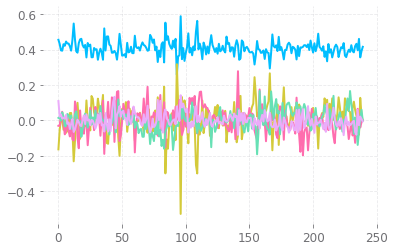

In [306]:
plt.plot(Factors.T.values)

In [308]:
Gamma

,0,1,2,3,4
A2ME,0.485289,-0.105882,-0.257739,-0.218769,0.055338
AC,0.035715,-0.050916,-0.015234,-0.058490,0.037240
AT,-0.072397,-0.347041,0.076957,-0.038999,0.032718
ATO,0.082339,0.001534,0.012201,-0.097195,-0.086933
BEME,0.261850,0.086397,-0.084106,0.113983,-0.116108
Beta,0.006342,0.003798,-0.027872,-0.023069,0.554245
C,0.112988,0.030565,-0.025348,0.030786,-0.015661
CF,0.083393,-0.000507,-0.019978,0.007821,-0.017924
CF2P,-0.036978,0.077533,0.012938,0.075145,-0.009196
CTO,-0.309002,0.086495,-0.169719,0.156650,-0.053901


In [8]:
import numpy as np
from statsmodels.datasets import grunfeld
data = grunfeld.load_pandas().data
data.year = data.year.astype(np.int64)

# Establish unique IDs to conform with package
N = len(np.unique(data.firm))
ID = dict(zip(np.unique(data.firm).tolist(),np.arange(1,N+1)))
data.firm = data.firm.apply(lambda x: ID[x])

# use multi-index for panel groups
data = data.set_index(['firm', 'year'])
y = data['invest']
X = data.drop('invest', axis=1)

# Call ipca
from ipca import InstrumentedPCA
regr = InstrumentedPCA(n_factors=1, intercept=False)
regr = regr.fit(X=X, y=y)
Gamma, Factors = regr.get_factors(label_ind=True)

The panel dimensions are:
n_samples: 11 , L: 2 , T: 20


Step 1 - Aggregate Update: 991040.1067154527
Step 2 - Aggregate Update: 0.031168457034450703
Step 3 - Aggregate Update: 0.013774627857863875
Step 4 - Aggregate Update: 0.0060456374632660015
Step 5 - Aggregate Update: 0.0026463970950459936
Step 6 - Aggregate Update: 0.0011571703804040545
Step 7 - Aggregate Update: 0.0005057548444780402
Step 8 - Aggregate Update: 0.00022100228661872667
Step 9 - Aggregate Update: 9.656419373593739e-05
Step 10 - Aggregate Update: 4.2190938680158885e-05
Step 11 - Aggregate Update: 1.8433811879242645e-05
Step 12 - Aggregate Update: 8.053932980756073e-06
-- Convergence Reached --


In [9]:
Gamma

,0
value,0.991659
capital,0.128886


In [10]:
Factors

,1935,1936,1937,1938,1939,1940,1941,1942,1943,1944,1945,1946,1947,1948,1949,1950,1951,1952,1953,1954
0,0.103197,0.088449,0.08385,0.084507,0.072252,0.099507,0.122884,0.142262,0.119753,0.117973,0.108756,0.135752,0.157935,0.166054,0.148492,0.158663,0.159601,0.175938,0.192169,0.211106


In [16]:
X

value  capital
firm year                   
6    1935  3078.500    2.800
     1936  4661.700   52.600
     1937  5387.100  156.900
     1938  2792.200  209.200
     1939  4313.200  203.400
...             ...      ...
1    1950    36.494   75.847
     1951    46.082   77.367
     1952    57.616   78.631
     1953    57.441   80.215
     1954    47.165   83.788

[220 rows x 2 columns]

In [14]:
data

invest     value  capital
firm year                            
6    1935  317.600  3078.500    2.800
     1936  391.800  4661.700   52.600
     1937  410.600  5387.100  156.900
     1938  257.700  2792.200  209.200
     1939  330.800  4313.200  203.400
...            ...       ...      ...
1    1950    4.770    36.494   75.847
     1951    6.532    46.082   77.367
     1952    7.329    57.616   78.631
     1953    9.020    57.441   80.215
     1954    6.281    47.165   83.788

[220 rows x 3 columns]